In [ ]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas as pd#gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-c0xi83ma
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-c0xi83ma
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_post = pd.read_csv('/content/drive/MyDrive/MA_Thesis/DBCommunity/saved_data/data_aca.csv')
df_reply = pd.read_csv('/content/drive/MyDrive/MA_Thesis/DBCommunity/saved_data/reply_aca.csv')
df_post.columns, df_reply.columns

(Index(['Title', 'Text', 'Author', 'Reply', 'LastReply', 'PublishTime', 'Like',
        'Collect', 'Repost', 'Community_name', 'seg_text', 'tokenized_text',
        'Reply_Year', 'Reply_Month', 'Reply_Day', 'Pub_Year', 'Pub_Month',
        'Pub_Day', 'normalized_text', 'tokenized_sentences', 'TopPost',
        'Length', 'Aca', 'active_author', 'active_reply_author'],
       dtype='object'),
 Index(['Title', 'Author', 'Reply_author', 'reply_author_id', 'reply_content',
        'reply_pubtime', 'comment_like'],
       dtype='object'))

In [ ]:
df_sentiment = pd.read_csv('/content/drive/MyDrive/MA_Thesis/DBCommunity/saved_data/sentiment.csv')
df_support_direction = pd.read_csv('/content/drive/MyDrive/MA_Thesis/DBCommunity/saved_data/deepseek.csv')
df_sentiment.columns, df_support_direction.columns

(Index(['Title', 'Text', 'Author', 'Reply', 'LastReply', 'PublishTime', 'Like',
        'Collect', 'Repost', 'Community_name', 'seg_text', 'tokenized_text',
        'Reply_Year', 'Reply_Month', 'Reply_Day', 'Pub_Year', 'Pub_Month',
        'Pub_Day', 'normalized_text', 'tokenized_sentences', 'TopPost',
        'Length', 'Aca', 'active_author', 'active_reply_author',
        'sentiment_label', 'sentiment_score'],
       dtype='object'),
 Index(['id', 'Category'], dtype='object'))

# Edgelist construction

In [ ]:
# Ensure reply_pubtime is in datetime format
df_reply['reply_pubtime'] = pd.to_datetime(df_reply['reply_pubtime'])

# Filter rows with dates before 2024
df_reply = df_reply[df_reply['reply_pubtime'].dt.year < 2024]

df_post.shape, df_reply.shape, df_sentiment.shape, df_support_direction.shape

((5254, 25), (10093, 7), (5254, 27), (5261, 2))

In [ ]:
# prompt: eliminate all the duplicayed rows in df_support_direction

df_support_direction = df_support_direction.drop_duplicates()


In [ ]:
df_support_direction.shape

(5254, 2)

In [ ]:
df_reply.head()

,Title,Author,Reply_author,reply_author_id,reply_content,reply_pubtime,comment_like
0,小组活动｜🎉小组官方slack群建立啦!🎉,Anon加重音,Wollstonecraft,154742699,支持！,2020-10-09 08:46:52,7
1,小组活动｜🎉小组官方slack群建立啦!🎉,Anon加重音,树懒,xtopia,dd支持,2020-10-09 09:16:52,0
2,小组活动｜🎉小组官方slack群建立啦!🎉,Anon加重音,小小脑袋,149862817,dd支持,2020-10-09 09:22:28,0
3,小组活动｜🎉小组官方slack群建立啦!🎉,Anon加重音,沐沫沫,197316067,加入啦！,2020-10-09 09:24:35,0
4,小组活动｜🎉小组官方slack群建立啦!🎉,Anon加重音,かん,183851723,dd,2020-10-09 09:29:19,0


In [ ]:
df_reply.shape

(10093, 7)

In [ ]:
# prompt: create a new dataframe combines df_sentiment and df_support_direction through the index of the former and the "id" column of the latter

# Assuming df_sentiment's index is the joining key and df_support_direction has an "id" column
combined_df = pd.merge(df_sentiment, df_support_direction, left_index=True, right_on='id', how='inner')
combined_df.columns

Index(['Title', 'Text', 'Author', 'Reply', 'LastReply', 'PublishTime', 'Like',
       'Collect', 'Repost', 'Community_name', 'seg_text', 'tokenized_text',
       'Reply_Year', 'Reply_Month', 'Reply_Day', 'Pub_Year', 'Pub_Month',
       'Pub_Day', 'normalized_text', 'tokenized_sentences', 'TopPost',
       'Length', 'Aca', 'active_author', 'active_reply_author',
       'sentiment_label', 'sentiment_score', 'id', 'Category'],
      dtype='object')

In [ ]:
combined_df[['Title','Text','Category']][300:320]

,Title,Text,Category
307,关于港校申博的bg问题,uu们想问一下关于港大、港中文法学phd申请的bg，楼主本科双非法本 ，研究生top5 98...,0
308,想去加拿大读博，提前一年进该组做科研助理是否可行？,谢谢大家提醒！加拿大学签这事儿我了解了！我现在人在爱尔兰，上个月硕士毕业，我准备申请24fa...,0
309,费曼学习法找1-2位学习搭子，每日进行学习经验知识的分享讲解,楼主是文学方向，主要是古代文学，历史，学术，阅读写作的分享。希望能类似的方向。时间是每天早或...,1
310,请教gap year内申请research assistant的问题,楼主目前本科刚毕业，gap year准备寻找自己喜欢的研究方向，想去做个research a...,0
311,请问德国岗位制先给1.5年funding没有cover 全部时间是正常的么,///9.12更新就是导师只能保证给1.5年的合同之后的合同之后再定，总体5年的博，怎么想怎...,0
312,关于港校申博的bg问题,uu们想问一下关于港大、港中文法学phd申请的bg，楼主本科双非法本 ，研究生top5 98...,0
313,想去加拿大读博，提前一年进该组做科研助理是否可行？,谢谢大家提醒！加拿大学签这事儿我了解了！我现在人在爱尔兰，上个月硕士毕业，我准备申请24fa...,0
314,费曼学习法找1-2位学习搭子，每日进行学习经验知识的分享讲解,楼主是文学方向，主要是古代文学，历史，学术，阅读写作的分享。希望能类似的方向。时间是每天早或...,1
315,请教gap year内申请research assistant的问题,楼主目前本科刚毕业，gap year准备寻找自己喜欢的研究方向，想去做个research a...,0
316,陶瓷一个系两个老师可行吗,😭已看过很多建议，说一个系的老师会经常交流、不要网撒到一个学校里的一个系让教授们觉得你是海王...,0


In [ ]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.7 MB/s eta 0:00:00


In [ ]:
from rapidfuzz import process, fuzz

### Step 1: Match by Title Using Fuzzy Matching ###
# Function to find the best matching title
def match_title(title, title_list, threshold=80):
    best_match, score, _ = process.extractOne(title, title_list, scorer=fuzz.ratio)
    return best_match if score >= threshold else None

# Get unique titles from combined_df
combined_titles = combined_df['Title'].unique().tolist()

# Apply fuzzy matching to find the closest matching title
df_reply['Matched_Title'] = df_reply['Title'].apply(lambda x: match_title(x, combined_titles))

# Drop duplicates in combined_df to ensure one-to-one mapping
title_mapping = combined_df[['Title', 'Category', 'Author']].drop_duplicates(subset=['Title'])

# Merge df_reply with combined_df based on matched Title (renaming to avoid conflicts)
df_reply = df_reply.merge(title_mapping, left_on='Matched_Title', right_on='Title', how='left', suffixes=('', '_combined'))

# Ensure we only rename if 'Author_combined' exists
if 'Author_combined' in df_reply.columns:
    df_reply.rename(columns={'Author_combined': 'Matched_Author'}, inplace=True)

# Ensure we only drop 'Title_y' if it was created
if 'Title_y' in df_reply.columns:
    df_reply.drop(columns=['Title_y'], inplace=True)

### Step 2: Handle Unmatched Rows Using Author Matching ###
# Identify rows where Category is still missing after Title matching
unmatched_rows = df_reply['Category'].isna()

# Create a mapping from Author to Category for unmatched cases
author_mapping = combined_df[['Author', 'Category']].drop_duplicates(subset=['Author']).set_index('Author')['Category']

# Fill missing Category values using Author matching
df_reply.loc[unmatched_rows, 'Category'] = df_reply.loc[unmatched_rows, 'Author'].map(author_mapping)

# Ensure row count remains unchanged
assert df_reply.shape[0] == 10093, "Row count changed! Check for unexpected duplicates."



In [ ]:
combined_df.columns

Index(['Title', 'Text', 'Author', 'Reply', 'LastReply', 'PublishTime', 'Like',
       'Collect', 'Repost', 'Community_name', 'seg_text', 'tokenized_text',
       'Reply_Year', 'Reply_Month', 'Reply_Day', 'Pub_Year', 'Pub_Month',
       'Pub_Day', 'normalized_text', 'tokenized_sentences', 'TopPost',
       'Length', 'Aca', 'active_author', 'active_reply_author',
       'sentiment_label', 'sentiment_score', 'id', 'Category'],
      dtype='object')

In [ ]:
df_reply.columns

Index(['Title', 'Author', 'Reply_author', 'reply_author_id', 'reply_content',
       'reply_pubtime', 'comment_like', 'Matched_Title', 'Title_combined',
       'Category', 'Matched_Author'],
      dtype='object')

In [ ]:
# prompt: number of missing value of "Category" in df_reply

df_reply['Category'].isnull().sum()


133

In [ ]:
df_reply['Category']

,Category
0,1
1,1
2,1
3,1
4,1
...,...
10088,0
10089,0
10090,0
10091,0


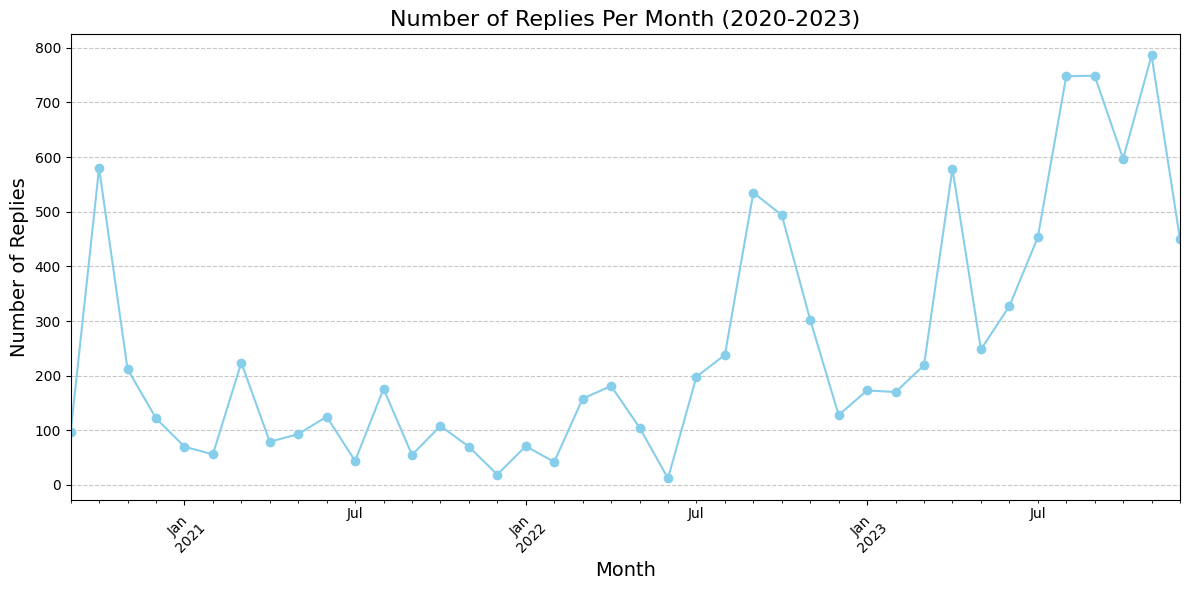

In [ ]:
# Extract year and month from reply_pubtime
df_reply['YearMonth'] = df_reply['reply_pubtime'].dt.to_period('M')

# Count the number of replies per month
replies_per_month = df_reply.groupby('YearMonth').size()

# Convert the index to a timestamp for proper plotting
replies_per_month.index = replies_per_month.index.to_timestamp()

# Plot the number of replies per month
plt.figure(figsize=(12, 6))
replies_per_month.plot(kind='line', marker='o', color='skyblue')
plt.title('Number of Replies Per Month (2020-2023)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Replies', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

# Indexing

In [ ]:
combined_df.columns

Index(['Title', 'Text', 'Author', 'Reply', 'LastReply', 'PublishTime', 'Like',
       'Collect', 'Repost', 'Community_name', 'seg_text', 'tokenized_text',
       'Reply_Year', 'Reply_Month', 'Reply_Day', 'Pub_Year', 'Pub_Month',
       'Pub_Day', 'normalized_text', 'tokenized_sentences', 'TopPost',
       'Length', 'Aca', 'active_author', 'active_reply_author',
       'sentiment_label', 'sentiment_score', 'id', 'Category'],
      dtype='object')

In [ ]:
df_reply.columns

Index(['Title', 'Author', 'Reply_author', 'reply_author_id', 'reply_content',
       'reply_pubtime', 'comment_like', 'Matched_Title', 'Title_combined',
       'Category', 'Matched_Author', 'YearMonth'],
      dtype='object')

In [ ]:
### Step 1: Assign Unique Author Indices in `combined_df`
# Create a mapping of unique authors to a numerical index
author_to_id = {author: idx for idx, author in enumerate(combined_df['Author'].unique(), start=1)}

# Assign Author_ID to combined_df
combined_df['Author_ID'] = combined_df['Author'].map(author_to_id)

### Step 2: Assign Unique Post Indices in `combined_df`
# Create a mapping of unique posts (by Title) to a numerical index
post_to_id = {title: idx for idx, title in enumerate(combined_df['Title'].unique(), start=1)}

# Assign Post_ID to combined_df
combined_df['Post_ID'] = combined_df['Title'].map(post_to_id)

### Step 3: Assign Corresponding Indices in `df_reply`
# Assign Author_ID to df_reply based on existing mapping
df_reply['Author_ID'] = df_reply['Author'].map(author_to_id)

# Assign Post_ID to df_reply using the matched title
df_reply['Post_ID'] = df_reply['Matched_Title'].map(post_to_id)

### Step 4: Handle Missing Author_IDs in df_reply ###
# Find authors in df_reply that were not in combined_df
missing_authors = df_reply[df_reply['Author_ID'].isna()]['Author'].unique()

# Assign new unique IDs starting after the last assigned ID
new_author_ids = {author: idx for idx, author in enumerate(missing_authors, start=len(author_to_id) + 1)}

# Update the main author mapping with new authors
author_to_id.update(new_author_ids)

# Fill in the missing Author_IDs
df_reply['Author_ID'] = df_reply['Author_ID'].fillna(df_reply['Author'].map(new_author_ids))

### Step 5: Handle Missing Post_IDs in df_reply ###
# Find titles in df_reply that were not in combined_df
missing_titles = df_reply[df_reply['Post_ID'].isna()]['Matched_Title'].unique()

# Assign new unique IDs starting after the last assigned ID
new_post_ids = {title: idx for idx, title in enumerate(missing_titles, start=len(post_to_id) + 1)}

# Update the main post mapping with new titles
post_to_id.update(new_post_ids)

# Fill in the missing Post_IDs
df_reply['Post_ID'] = df_reply['Post_ID'].fillna(df_reply['Matched_Title'].map(new_post_ids))

### Step 6: Convert IDs to Integers ###
df_reply['Author_ID'] = df_reply['Author_ID'].astype(int)
df_reply['Post_ID'] = df_reply['Post_ID'].astype(int)

### Step 7: Display the updated dataframes ###
combined_df.columns, df_reply.columns


(Index(['Title', 'Text', 'Author', 'Reply', 'LastReply', 'PublishTime', 'Like',
        'Collect', 'Repost', 'Community_name', 'seg_text', 'tokenized_text',
        'Reply_Year', 'Reply_Month', 'Reply_Day', 'Pub_Year', 'Pub_Month',
        'Pub_Day', 'normalized_text', 'tokenized_sentences', 'TopPost',
        'Length', 'Aca', 'active_author', 'active_reply_author',
        'sentiment_label', 'sentiment_score', 'id', 'Category', 'Author_ID',
        'Post_ID'],
       dtype='object'),
 Index(['Title', 'Author', 'Reply_author', 'reply_author_id', 'reply_content',
        'reply_pubtime', 'comment_like', 'Matched_Title', 'Title_combined',
        'Category', 'Matched_Author', 'YearMonth', 'Author_ID', 'Post_ID'],
       dtype='object'))

In [ ]:
combined_df.shape, df_reply.shape

((5254, 31), (10093, 14))

In [ ]:
### Step 1: Assign Existing Author_IDs to Reply_author ###
df_reply['Reply_Author_ID'] = df_reply['Reply_author'].map(author_to_id)

### Step 2: Handle Missing Reply_Author_IDs ###
# Find Reply_authors that were not indexed before
missing_reply_authors = df_reply[df_reply['Reply_Author_ID'].isna()]['Reply_author'].unique()

# Assign new unique IDs starting after the last assigned ID
new_reply_author_ids = {author: idx for idx, author in enumerate(missing_reply_authors, start=len(author_to_id) + 1)}

# Update the main author mapping with new reply authors
author_to_id.update(new_reply_author_ids)

# Fill in the missing Reply_Author_IDs
df_reply['Reply_Author_ID'] = df_reply['Reply_Author_ID'].fillna(df_reply['Reply_author'].map(new_reply_author_ids))

### Step 3: Convert IDs to Integers ###
df_reply['Reply_Author_ID'] = df_reply['Reply_Author_ID'].astype(int)

### Step 4: Display the updated dataframe
combined_df.columns, df_reply.columns


(Index(['Title', 'Text', 'Author', 'Reply', 'LastReply', 'PublishTime', 'Like',
        'Collect', 'Repost', 'Community_name', 'seg_text', 'tokenized_text',
        'Reply_Year', 'Reply_Month', 'Reply_Day', 'Pub_Year', 'Pub_Month',
        'Pub_Day', 'normalized_text', 'tokenized_sentences', 'TopPost',
        'Length', 'Aca', 'active_author', 'active_reply_author',
        'sentiment_label', 'sentiment_score', 'id', 'Category', 'Author_ID',
        'Post_ID'],
       dtype='object'),
 Index(['Title', 'Author', 'Reply_author', 'reply_author_id', 'reply_content',
        'reply_pubtime', 'comment_like', 'Matched_Title', 'Title_combined',
        'Category', 'Matched_Author', 'YearMonth', 'Author_ID', 'Post_ID',
        'Reply_Author_ID'],
       dtype='object'))

In [ ]:
combined_df.shape, df_reply.shape

((5254, 31), (10093, 15))

In [ ]:
df_reply[df_reply['Post_ID']==100]

,Title,Author,Reply_author,reply_author_id,reply_content,reply_pubtime,comment_like,Matched_Title,Title_combined,Category,Matched_Author,YearMonth,Author_ID,Post_ID,Reply_Author_ID
5210,提问/讨论｜人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,Sajay,略,211637723,wokao…是不是新传的啊,2023-11-19 08:05:31,13,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,0,Sajay,2023-11,83,100,4140
5211,提问/讨论｜人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,Sajay,略,211637723,真的吐了，帮lz顶顶,2023-11-19 08:16:54,0,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,0,Sajay,2023-11,83,100,4140
5212,提问/讨论｜人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,Sajay,周树人的笔名,153137639,帮顶,2023-11-19 23:36:42,2,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,0,Sajay,2023-11,83,100,4141
5213,提问/讨论｜人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,Sajay,速冻电音小熊,121375247,要不要先问问导师，或者看一下审稿人之前的研究方向,2023-11-30 07:42:54,3,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,0,Sajay,2023-11,83,100,4142
5214,提问/讨论｜人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,Sajay,李知恩,183568013,吐了 可别是新传，我一直感觉传头部那群人idea快到头了，这些年的产出越来越不如以前了,2023-11-30 13:12:17,6,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,0,Sajay,2023-11,83,100,4143
5215,提问/讨论｜人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,Sajay,再劝娇妻我是狗,173138853,你导人品怎么样，如果他人品好，这个事你可以问问他该怎么处理。,2023-12-01 18:48:13,2,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,0,Sajay,2023-12,83,100,4042
5216,提问/讨论｜人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,Sajay,Yuki,FMyuki,帮顶,2023-12-09 00:28:33,0,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,0,Sajay,2023-12,83,100,1535


In [ ]:
combined_df[combined_df['Post_ID']==100]

,Title,Text,Author,Reply,LastReply,PublishTime,Like,Collect,Repost,Community_name,...,Length,Aca,active_author,active_reply_author,sentiment_label,sentiment_score,id,Category,Author_ID,Post_ID
113,人文社科，发现C刊审稿人可能拒了我的稿件后借我的idea写了论文,对方是国内学术明星，我是国内硕士在读。这篇质化研究论文是我研一时的一门结课作业，去年独作投稿...,Sajay,7,2023-12-09,2023-11-17,3,3,2,Academia,...,257,1.0,0,0,positive,1.0,113,0,83,100


In [ ]:
df_reply_refined = df_reply[['Title', 'Post_ID', 'Author', 'Author_ID',
                             'Reply_author', 'Reply_Author_ID', 'reply_content',
                             'reply_pubtime', 'comment_like', 'Category']]
df_reply_refined.head()

,Title,Post_ID,Author,Author_ID,Reply_author,Reply_Author_ID,reply_content,reply_pubtime,comment_like,Category
0,小组活动｜🎉小组官方slack群建立啦!🎉,4334,Anon加重音,1,Wollstonecraft,1983,支持！,2020-10-09 08:46:52,7,1
1,小组活动｜🎉小组官方slack群建立啦!🎉,4334,Anon加重音,1,树懒,2479,dd支持,2020-10-09 09:16:52,0,1
2,小组活动｜🎉小组官方slack群建立啦!🎉,4334,Anon加重音,1,小小脑袋,1297,dd支持,2020-10-09 09:22:28,0,1
3,小组活动｜🎉小组官方slack群建立啦!🎉,4334,Anon加重音,1,沐沫沫,2202,加入啦！,2020-10-09 09:24:35,0,1
4,小组活动｜🎉小组官方slack群建立啦!🎉,4334,Anon加重音,1,かん,2387,dd,2020-10-09 09:29:19,0,1


In [ ]:
# prompt: store df_reply as "edgelist.csv"

df_reply_refined.to_csv('/content/drive/MyDrive/MA_Thesis/DBCommunity/saved_data/edgelist.csv', index=False)


In [ ]:
combined_df.columns

Index(['Title', 'Text', 'Author', 'Reply', 'LastReply', 'PublishTime', 'Like',
       'Collect', 'Repost', 'Community_name', 'seg_text', 'tokenized_text',
       'Reply_Year', 'Reply_Month', 'Reply_Day', 'Pub_Year', 'Pub_Month',
       'Pub_Day', 'normalized_text', 'tokenized_sentences', 'TopPost',
       'Length', 'Aca', 'active_author', 'active_reply_author',
       'sentiment_label', 'sentiment_score', 'id', 'Category', 'Author_ID',
       'Post_ID'],
      dtype='object')

In [ ]:
df = combined_df[['Title', 'Post_ID', 'Text', 'Author', 'Author_ID', 'Reply',
                  'LastReply', 'PublishTime', 'Like', 'Collect', 'Repost',
                  'Length', 'active_author', 'active_reply_author',
                  'sentiment_label', 'sentiment_score', 'Category']]
df.head()

,Title,Post_ID,Text,Author,Author_ID,Reply,LastReply,PublishTime,Like,Collect,Repost,Length,active_author,active_reply_author,sentiment_label,sentiment_score,Category
0,精华\n\n\n \n ...,1,由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...,Anon加重音,1,1115,2023-12-21,2020-10-09,2,4,4,313,1,1,positive,9.077597e-01,1
1,精华\n\n\n \n ...,2,—————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...,Anon加重音,1,64,2023-12-01,2020-10-14,1,2,1,67,1,1,negative,1.599090e-01,1
2,精华\n\n\n \n ...,3,前情(意见征集贴) https://www.douban.com/group/topic/1...,Anon加重音,1,12,2023-07-04,2020-10-10,4,6,4,244,1,1,positive,1.000000e+00,1
3,精华\n\n\n \n ...,4,论坛第二期分享会她说PhD：不同的人生路径的文字稿和音频分享来啦。非常感谢小组长们的全力支持...,Sophie,2,2,2023-05-03,2020-11-02,1,6,0,177,1,0,positive,9.999413e-01,1
4,精华\n\n\n \n ...,5,09/30/21更新: 管理员实在是没有能力及时追踪所有申请相关的帖子，大家有相关的帖子想要...,丸子,3,6,2023-03-25,2020-12-09,2,2,1,478,1,0,negative,2.440807e-08,1


# Frequency calculation (active user)

In [ ]:
# Create a temporary sorted dataframe to compute post counts
temp_df = df[['Author', 'PublishTime']].copy()
temp_df['PostCount'] = temp_df.groupby('Author').cumcount() + 1

# Map the computed post count back to the original dataframe
df['PostCount'] = temp_df['PostCount']

df[20:40]

<ipython-input-47-58ab560619ee>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PostCount'] = temp_df['PostCount']


,Title,Post_ID,Text,Author,Author_ID,Reply,LastReply,PublishTime,Like,Collect,Repost,Length,active_author,active_reply_author,sentiment_label,sentiment_score,Category,PostCount
20,精华\n\n\n \n ...,21,哇哇哇感谢加精！！感觉本组欧美博比较多，咱就是说一年40w又离家近它不香吗555感兴趣的朋友...,Phagee,15,39,2024-01-11,2023-10-17,2,4,1,83,0,1,positive,0.999999,1,1
21,建立CS/AI面试mock/经验分享群 | 最好24fall,22,大家好，因为最近24FALL申请季到了很多面试的时间，希望能组织方向相近的姐妹一起mock或...,T,16,0,2024-01-11,2024-01-11,0,0,0,105,0,1,positive,0.999859,1,1
22,申phd能否交一份类似research progress/progress report之类...,23,我的硕士课题目前进行到2/3，有一些数据可以成文，但是老师不让发文章，但我想体现在我的phd...,一朵忽地笑,17,3,2024-01-11,2024-01-02,0,0,0,128,1,0,positive,1.000000,0,1
23,精华\n\n\n \n ...,24,今天csc联培的结果出来啦～获得了资助，各位uu有任何问题都可以留言提问，长期有效，看到就会...,无弈,18,18,2024-01-10,2023-07-26,3,9,1,933,0,1,positive,1.000000,1,1
24,phd 研究方向-gpt4后的机器学习人该怎么考虑未来研究方向的选择,25,本人是做机器学习交叉学科应用的菜鸡一个，平时就觉得自己的研究内容没有竞争力，cs 专业读研后...,遗忘边境,19,14,2024-01-10,2023-03-15,1,2,3,142,0,0,positive,1.000000,0,1
25,这个组有会计类专业的研究生女性嘛,26,…想问一些专业类的问题#会计已经很难学了，英语类会计是最难学的#,打的一拳开,20,8,2024-01-10,2024-01-03,0,0,0,23,0,0,positive,0.985861,0,1
26,北美24Fall询问,27,24fall心碎瞬间，至今没有收到任何面试邀请，想问问组里的姐妹要不要写follow up ...,246ts,21,4,2024-01-10,2024-01-08,1,0,0,47,1,0,positive,0.802384,0,1
27,请问澳门城市大学怎么样？,28,自己导师可以推荐去澳城读博，人文社科，看招生简章学费稍贵，虽然也能承受，但不想读博还花钱。我...,阿尼肯得,22,0,2024-01-10,2024-01-10,0,0,0,60,0,0,positive,0.999998,0,1
28,读博熬过了最艰难的开头，现在一马平川😬,29,毕业后工作了2-3年，觉得自己不太适合在公司里干，回来读博了，希望留在学术界。因为以前没有很...,小雨点,23,7,2024-01-10,2022-05-12,3,0,0,100,1,0,positive,1.000000,1,1
29,（已解决）该不该跨专业申请海外哲学phd,30,谢谢家人们回复！每个建议我都看了♥️结合家人们说的就业、本硕背景和毕业难度，目前是放弃这个想...,momo,7,12,2024-01-10,2024-01-08,2,4,2,205,0,0,positive,1.000000,0,3


In [ ]:
df_reply_refined

,Title,Post_ID,Author,Author_ID,Reply_author,Reply_Author_ID,reply_content,reply_pubtime,comment_like,Category
0,小组活动｜🎉小组官方slack群建立啦!🎉,4334,Anon加重音,1,Wollstonecraft,1983,支持！,2020-10-09 08:46:52,7,1
1,小组活动｜🎉小组官方slack群建立啦!🎉,4334,Anon加重音,1,树懒,2479,dd支持,2020-10-09 09:16:52,0,1
2,小组活动｜🎉小组官方slack群建立啦!🎉,4334,Anon加重音,1,小小脑袋,1297,dd支持,2020-10-09 09:22:28,0,1
3,小组活动｜🎉小组官方slack群建立啦!🎉,4334,Anon加重音,1,沐沫沫,2202,加入啦！,2020-10-09 09:24:35,0,1
4,小组活动｜🎉小组官方slack群建立啦!🎉,4334,Anon加重音,1,かん,2387,dd,2020-10-09 09:29:19,0,1
...,...,...,...,...,...,...,...,...,...,...
10088,读博的意义到底是什么？,354,每天锻炼,2478,Rough Rib,4735,最近也有频繁思考这个问题，对我来说，好像能够读书获取新的知识、一定表达自我的空间以及对我的生...,2023-07-29 14:41:57,1,0
10089,读博的意义到底是什么？,354,每天锻炼,2478,每天锻炼,2478,我对生活完全没有掌控感，是生活在掌控我,2023-07-29 16:53:17,1,0
10090,读博的意义到底是什么？,354,每天锻炼,2478,Rough Rib,4735,懂。楼主慢慢调整，希望能好起来！,2023-07-29 17:16:58,1,0
10091,读博的意义到底是什么？,354,每天锻炼,2478,一逸孤行,4736,对我的意义就是想在喜欢的地方多待几年\n课题是喜欢的，特意选了非纯文，打了三四份工，谈了恋爱...,2023-08-03 05:43:57,3,0


In [ ]:
# Ensure datetime format
df['PublishTime'] = pd.to_datetime(df['PublishTime'])
df_reply_refined['reply_pubtime'] = pd.to_datetime(df_reply_refined['reply_pubtime'])

# Create a temporary dataframe to track cumulative reply counts
df_reply_refined = df_reply_refined.sort_values(by='reply_pubtime')  # Ensure chronological order
df_reply_refined['ReplyCount_Cumulative'] = df_reply_refined.groupby('Reply_Author_ID').cumcount() + 1

# Merge cumulative reply count back to df based on the author and time condition
df['ReplyCount'] = df.apply(lambda row: df_reply_refined[
    (df_reply_refined['Reply_Author_ID'] == row['Author_ID']) &
    (df_reply_refined['reply_pubtime'] < row['PublishTime'])
]['ReplyCount_Cumulative'].max(), axis=1)

# Fill NaN values with 0 (if no replies were made before the post)
df['ReplyCount'] = df['ReplyCount'].fillna(0).astype(int)

df[20:40]

<ipython-input-49-0d618123e624>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PublishTime'] = pd.to_datetime(df['PublishTime'])
<ipython-input-49-0d618123e624>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reply_refined['reply_pubtime'] = pd.to_datetime(df_reply_refined['reply_pubtime'])
<ipython-input-49-0d618123e624>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,Title,Post_ID,Text,Author,Author_ID,Reply,LastReply,PublishTime,Like,Collect,Repost,Length,active_author,active_reply_author,sentiment_label,sentiment_score,Category,PostCount,ReplyCount
20,精华\n\n\n \n ...,21,哇哇哇感谢加精！！感觉本组欧美博比较多，咱就是说一年40w又离家近它不香吗555感兴趣的朋友...,Phagee,15,39,2024-01-11,2023-10-17,2,4,1,83,0,1,positive,0.999999,1,1,2
21,建立CS/AI面试mock/经验分享群 | 最好24fall,22,大家好，因为最近24FALL申请季到了很多面试的时间，希望能组织方向相近的姐妹一起mock或...,T,16,0,2024-01-11,2024-01-11,0,0,0,105,0,1,positive,0.999859,1,1,6
22,申phd能否交一份类似research progress/progress report之类...,23,我的硕士课题目前进行到2/3，有一些数据可以成文，但是老师不让发文章，但我想体现在我的phd...,一朵忽地笑,17,3,2024-01-11,2024-01-02,0,0,0,128,1,0,positive,1.000000,0,1,0
23,精华\n\n\n \n ...,24,今天csc联培的结果出来啦～获得了资助，各位uu有任何问题都可以留言提问，长期有效，看到就会...,无弈,18,18,2024-01-10,2023-07-26,3,9,1,933,0,1,positive,1.000000,1,1,1
24,phd 研究方向-gpt4后的机器学习人该怎么考虑未来研究方向的选择,25,本人是做机器学习交叉学科应用的菜鸡一个，平时就觉得自己的研究内容没有竞争力，cs 专业读研后...,遗忘边境,19,14,2024-01-10,2023-03-15,1,2,3,142,0,0,positive,1.000000,0,1,0
25,这个组有会计类专业的研究生女性嘛,26,…想问一些专业类的问题#会计已经很难学了，英语类会计是最难学的#,打的一拳开,20,8,2024-01-10,2024-01-03,0,0,0,23,0,0,positive,0.985861,0,1,0
26,北美24Fall询问,27,24fall心碎瞬间，至今没有收到任何面试邀请，想问问组里的姐妹要不要写follow up ...,246ts,21,4,2024-01-10,2024-01-08,1,0,0,47,1,0,positive,0.802384,0,1,0
27,请问澳门城市大学怎么样？,28,自己导师可以推荐去澳城读博，人文社科，看招生简章学费稍贵，虽然也能承受，但不想读博还花钱。我...,阿尼肯得,22,0,2024-01-10,2024-01-10,0,0,0,60,0,0,positive,0.999998,0,1,1
28,读博熬过了最艰难的开头，现在一马平川😬,29,毕业后工作了2-3年，觉得自己不太适合在公司里干，回来读博了，希望留在学术界。因为以前没有很...,小雨点,23,7,2024-01-10,2022-05-12,3,0,0,100,1,0,positive,1.000000,1,1,2
29,（已解决）该不该跨专业申请海外哲学phd,30,谢谢家人们回复！每个建议我都看了♥️结合家人们说的就业、本硕背景和毕业难度，目前是放弃这个想...,momo,7,12,2024-01-10,2024-01-08,2,4,2,205,0,0,positive,1.000000,0,3,1241


In [ ]:
# prompt: In df, all the rows that "Author" is "momo" should have PostCount as 0 and ReplyCount as 0.

df.loc[df['Author'] == 'momo', 'PostCount'] = 0
df.loc[df['Author'] == 'momo', 'ReplyCount'] = 0

df[20:40]

,Title,Post_ID,Text,Author,Author_ID,Reply,LastReply,PublishTime,Like,Collect,Repost,Length,active_author,active_reply_author,sentiment_label,sentiment_score,Category,PostCount,ReplyCount
20,精华\n\n\n \n ...,21,哇哇哇感谢加精！！感觉本组欧美博比较多，咱就是说一年40w又离家近它不香吗555感兴趣的朋友...,Phagee,15,39,2024-01-11,2023-10-17,2,4,1,83,0,1,positive,0.999999,1,1,2
21,建立CS/AI面试mock/经验分享群 | 最好24fall,22,大家好，因为最近24FALL申请季到了很多面试的时间，希望能组织方向相近的姐妹一起mock或...,T,16,0,2024-01-11,2024-01-11,0,0,0,105,0,1,positive,0.999859,1,1,6
22,申phd能否交一份类似research progress/progress report之类...,23,我的硕士课题目前进行到2/3，有一些数据可以成文，但是老师不让发文章，但我想体现在我的phd...,一朵忽地笑,17,3,2024-01-11,2024-01-02,0,0,0,128,1,0,positive,1.000000,0,1,0
23,精华\n\n\n \n ...,24,今天csc联培的结果出来啦～获得了资助，各位uu有任何问题都可以留言提问，长期有效，看到就会...,无弈,18,18,2024-01-10,2023-07-26,3,9,1,933,0,1,positive,1.000000,1,1,1
24,phd 研究方向-gpt4后的机器学习人该怎么考虑未来研究方向的选择,25,本人是做机器学习交叉学科应用的菜鸡一个，平时就觉得自己的研究内容没有竞争力，cs 专业读研后...,遗忘边境,19,14,2024-01-10,2023-03-15,1,2,3,142,0,0,positive,1.000000,0,1,0
25,这个组有会计类专业的研究生女性嘛,26,…想问一些专业类的问题#会计已经很难学了，英语类会计是最难学的#,打的一拳开,20,8,2024-01-10,2024-01-03,0,0,0,23,0,0,positive,0.985861,0,1,0
26,北美24Fall询问,27,24fall心碎瞬间，至今没有收到任何面试邀请，想问问组里的姐妹要不要写follow up ...,246ts,21,4,2024-01-10,2024-01-08,1,0,0,47,1,0,positive,0.802384,0,1,0
27,请问澳门城市大学怎么样？,28,自己导师可以推荐去澳城读博，人文社科，看招生简章学费稍贵，虽然也能承受，但不想读博还花钱。我...,阿尼肯得,22,0,2024-01-10,2024-01-10,0,0,0,60,0,0,positive,0.999998,0,1,1
28,读博熬过了最艰难的开头，现在一马平川😬,29,毕业后工作了2-3年，觉得自己不太适合在公司里干，回来读博了，希望留在学术界。因为以前没有很...,小雨点,23,7,2024-01-10,2022-05-12,3,0,0,100,1,0,positive,1.000000,1,1,2
29,（已解决）该不该跨专业申请海外哲学phd,30,谢谢家人们回复！每个建议我都看了♥️结合家人们说的就业、本硕背景和毕业难度，目前是放弃这个想...,momo,7,12,2024-01-10,2024-01-08,2,4,2,205,0,0,positive,1.000000,0,0,0


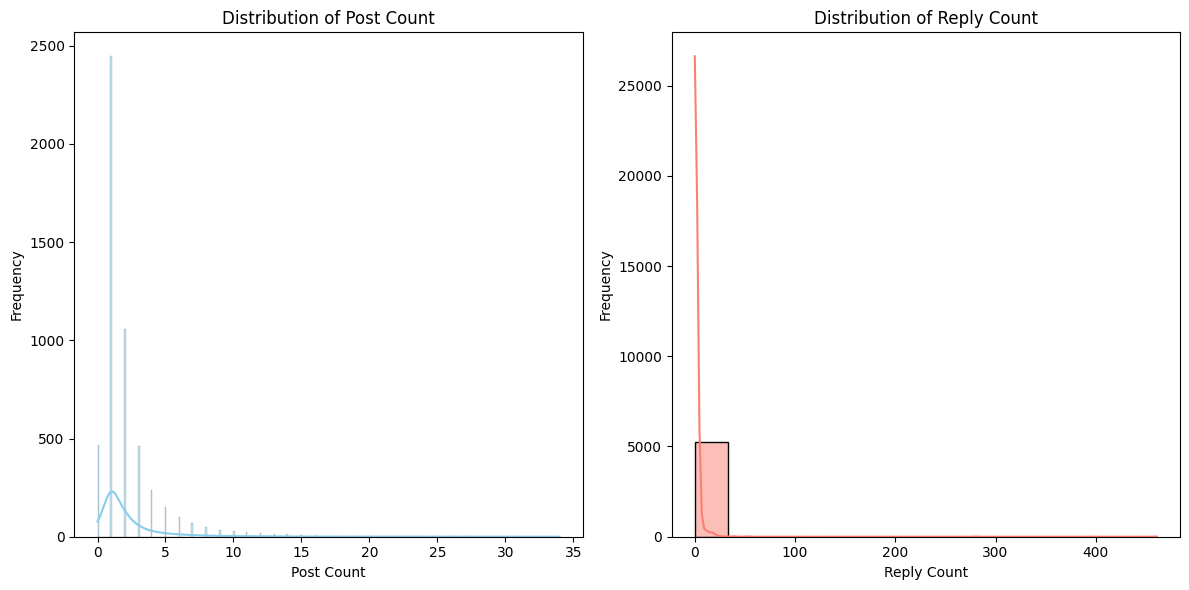

In [ ]:
# prompt: map the distribution of PostCount and ReplyCount

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame with 'PostCount' and 'ReplyCount' columns
plt.figure(figsize=(12, 6))

# Distribution of PostCount
plt.subplot(1, 2, 1)
sns.histplot(df['PostCount'], kde=True, color='skyblue')
plt.title('Distribution of Post Count')
plt.xlabel('Post Count')
plt.ylabel('Frequency')

# Distribution of ReplyCount
plt.subplot(1, 2, 2)
sns.histplot(df['ReplyCount'], kde=True, color='salmon')
plt.title('Distribution of Reply Count')
plt.xlabel('Reply Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
!pip install ace_tools

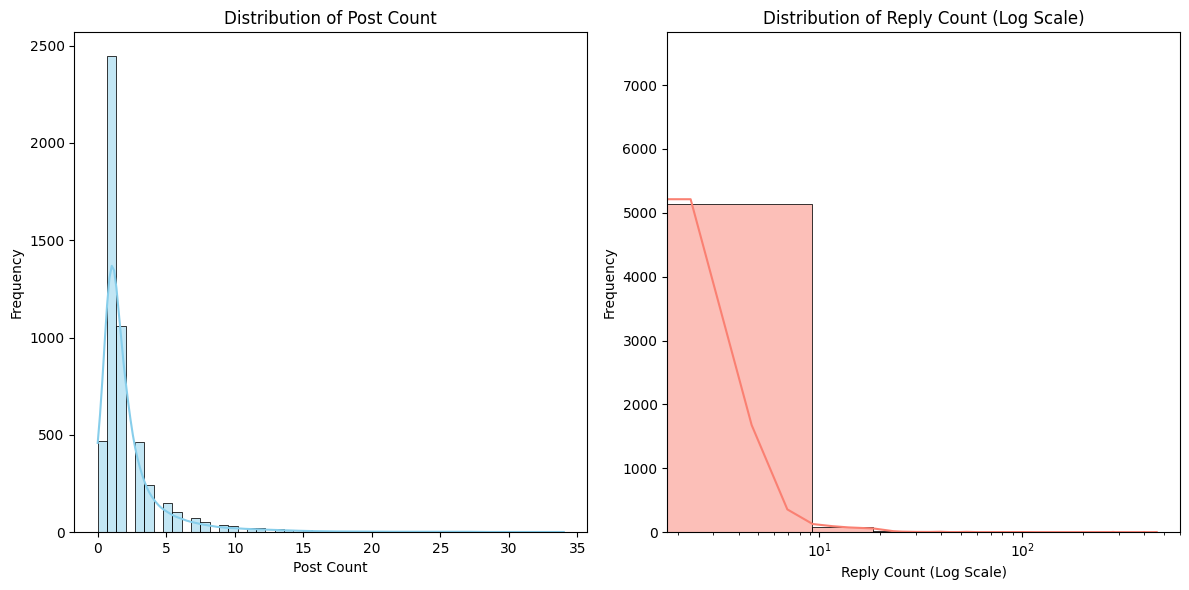

,Percentile,PostCount Threshold,ReplyCount Threshold
0,50,1.0,0.0
1,75,2.0,0.0
2,90,5.0,1.0
3,95,7.0,3.0
4,99,16.0,18.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set figure size
plt.figure(figsize=(12, 6))

# Distribution of PostCount
plt.subplot(1, 2, 1)
sns.histplot(df['PostCount'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Post Count')
plt.xlabel('Post Count')
plt.ylabel('Frequency')

# Distribution of ReplyCount with log scale
plt.subplot(1, 2, 2)
sns.histplot(df['ReplyCount'], bins=50, kde=True, color='salmon')
plt.xscale('log')  # Apply log scale for better visualization
plt.title('Distribution of Reply Count (Log Scale)')
plt.xlabel('Reply Count (Log Scale)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Define percentiles to analyze
percentiles = [50, 75, 90, 95, 99]

# Compute thresholds for both PostCount and ReplyCount
postcount_thresholds = np.percentile(df['PostCount'], percentiles)
replycount_thresholds = np.percentile(df['ReplyCount'], percentiles)

# Create a DataFrame with both thresholds
threshold_df = pd.DataFrame({
    'Percentile': percentiles,
    'PostCount Threshold': postcount_thresholds,
    'ReplyCount Threshold': replycount_thresholds
})
threshold_df



In [ ]:
# prompt: calculate the percentages that PostCount or ReplyCount are larger than 1

# Calculate percentages
post_count_percentage = (df['PostCount'] > 1).sum() / len(df) * 100
reply_count_percentage = (df['ReplyCount'] > 1).sum() / len(df) * 100

print(f"Percentage of PostCount > 1: {post_count_percentage:.2f}%")
print(f"Percentage of ReplyCount > 1: {reply_count_percentage:.2f}%")


Percentage of PostCount > 1: 44.52%
Percentage of ReplyCount > 1: 9.46%


#Male-exclusive policy

In [ ]:
# Create the "male_excluded" column
df['male_excluded'] = (df['PublishTime'] > pd.Timestamp('2022-07-31')).astype(int)

df.tail()

<ipython-input-58-6c9958305fe4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['male_excluded'] = (df['PublishTime'] > pd.Timestamp('2022-07-31')).astype(int)


,Title,Post_ID,Text,Author,Author_ID,Reply,LastReply,PublishTime,Like,Collect,Repost,Length,active_author,active_reply_author,sentiment_label,sentiment_score,Category,PostCount,ReplyCount,male_excluded
5230,分享一个本领域senior的采访内容,4331,这位前辈人非常好，成果很多，采访内容里虽然不少是本领域specific，但是其中关于pick...,路亦槑,2087,1,2020-09-19,2020-09-19,6,2,2,69,0,0,positive,0.988028,1,3,0,0
5231,精华\n\n\n \n ...,4332,组里真是人才济济呀，为了更好地整合与利用资源，将所有AMA帖子集合在这里，方便大家交流学习P...,Anon加重音,1,0,2020-09-19,2020-09-19,3,2,2,72,1,1,positive,0.999986,1,26,0,0
5232,AMA｜美国文理学院做教职（理科）,4333,如题，关于美国文理学院（理科）教职申请、工作日常、工作环境、晋升要求、职业发展，欢迎提问！先...,多喜子,2447,4,2020-09-19,2020-09-18,5,7,1,79,0,0,positive,0.990897,1,1,0,0
5233,精华\n\n\n \n ...,4332,组里真是人才济济呀，为了更好地整合与利用资源，将所有AMA帖子集合在这里，方便大家交流学习P...,Anon加重音,1,0,2020-09-19,2020-09-19,3,2,2,72,1,1,positive,0.999986,1,27,0,0
5234,AMA｜美国文理学院做教职（理科）,4333,如题，关于美国文理学院（理科）教职申请、工作日常、工作环境、晋升要求、职业发展，欢迎提问！先...,多喜子,2447,4,2020-09-19,2020-09-18,5,7,1,79,0,0,positive,0.990897,1,2,0,0


In [ ]:
# prompt: calculating the percentage of 1 in male_excluded

# Calculate the percentage of 1s in the 'male_excluded' column
percentage_male_excluded = (df['male_excluded'] == 1).sum() / len(df) * 100

print(f"Percentage of 1s in 'male_excluded': {percentage_male_excluded:.2f}%")


Percentage of 1s in 'male_excluded': 27.56%


# Network Analysis

In [ ]:
df_reply_refined

,Title,Post_ID,Author,Author_ID,Reply_author,Reply_Author_ID,reply_content,reply_pubtime,comment_like,Category,ReplyCount_Cumulative
7792,小组活动｜Academic write-in zoom group,4334,木辛ci,170,乌啦啦啦啦,2596,举手，我想试试看能不能养成早上写作习惯，时区东部。可以分成小组进行，看时间适配程度。我可以开...,2020-09-21 23:47:31,5,1,1
7793,小组活动｜Academic write-in zoom group,4334,木辛ci,170,lalalala,2627,我有兴趣参加，山地时区&amp;国内时间切换，目测半夜或者清晨写作时间有保障。,2020-09-22 00:12:27,0,1,1
7794,小组活动｜Academic write-in zoom group,4334,木辛ci,170,穂永絵里,4050,举手！我在伦敦，白天（上午/下午）都可！,2020-09-22 00:34:57,0,1,1
7795,小组活动｜Academic write-in zoom group,4334,木辛ci,170,木辛ci,170,"Got it. 我刚刚建了一个google sheet, 可以由相应地区的小伙伴做host。...",2020-09-22 01:00:07,1,1,1
7796,小组活动｜Academic write-in zoom group,4334,木辛ci,170,乌啦啦啦啦,2596,tentative hours EST 9:30-11:30 AM. I can do ev...,2020-09-22 01:09:03,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
4477,提问/讨论｜请问本科生入组科研状态应该是怎样的,36,momo,7,momo,7,555谢谢姐妹给出的建议，认真看完后非常有启发，我会再好好评估目前的状况并且做出改变的，反正...,2023-12-31 00:45:39,1,0,1239
3224,提问/讨论｜本人研三 民族学 想申请人类学PhD 求助各位友友‼️,12,momo,7,鹿其,882,姐妹研三的话应该对自己领域有什么活跃的学者和研究有一定认识了，去这些学者的机构和学校网页看,2023-12-31 01:12:47,1,0,1
3220,提问/讨论｜本人研三 民族学 想申请人类学PhD 求助各位友友‼️,12,momo,7,鹿其,882,姐妹研三的话应该对自己领域有什么活跃的学者和研究有一定认识了，去这些学者的机构和学校网页看,2023-12-31 01:12:47,1,0,2
3221,提问/讨论｜本人研三 民族学 想申请人类学PhD 求助各位友友‼️,12,momo,7,momo,7,不了解，我学校很烂……😂😂😂甚至我导师都不是民族学的,2023-12-31 17:15:48,0,0,1240


In [ ]:
# prompt: how many "momo" are there in "Reply_author"?

momo_count = df_reply['Reply_author'].str.contains('momo').sum()
print(f"The number of times 'momo' appears in 'Reply_author' is: {momo_count}")


The number of times 'momo' appears in 'Reply_author' is: 1280


In [ ]:
# prompt: a new dataframe "df_reply_wo_momo" elimininates all momo in df_reply_refined.

# Create df_reply_wo_momo by removing rows where 'Reply_author' contains 'momo'
df_reply_wo_momo = df_reply_refined[~df_reply_refined['Reply_author'].str.contains('momo')]
df_reply_refined.shape, df_reply_wo_momo.shape

((10093, 11), (8813, 11))

In [ ]:
import networkx as nx
import pandas as pd

### Step 1: Build the Directed Graph ###
G = nx.DiGraph()

# Add edges based on Category rules
for _, row in df_reply_wo_momo.iterrows():
    if row['Category'] == 1:
        G.add_edge(row['Author_ID'], row['Reply_Author_ID'])  # Author → Reply_author
    else:
        G.add_edge(row['Reply_Author_ID'], row['Author_ID'])  # Reply_author → Author



In [ ]:
### Step 2: Calculate Centralities ###

# In-degree (Number of replies received)
in_replies = dict(G.in_degree())

# Out-degree (Number of replies sent)
out_replies = dict(G.out_degree())

# In-Betweenness centrality (Influence in receiving)
in_betweenness = nx.betweenness_centrality(G, normalized=True, endpoints=True)

# Out-Betweenness centrality (Influence in sending)
out_betweenness = nx.betweenness_centrality(G.reverse(), normalized=True, endpoints=True)  # Reverse for outgoing paths




In [ ]:
### Step 3: Combine Results into a DataFrame ###
centrality_df = pd.DataFrame({
    'Node': list(G.nodes),
    'In_Replies': [in_replies.get(node, 0) for node in G.nodes],
    'Out_Replies': [out_replies.get(node, 0) for node in G.nodes],
    'In_Betweenness': [in_betweenness.get(node, 0) for node in G.nodes],
    'Out_Betweenness': [out_betweenness.get(node, 0) for node in G.nodes]
})

### Step 4: Display the Centrality Measures ###
centrality_df

,Node,In_Replies,Out_Replies,In_Betweenness,Out_Betweenness
0,2596,0,3,1.088745e-05,1.088745e-05
1,170,83,2,1.031745e-03,1.031745e-03
2,2627,0,2,1.078376e-05,1.078376e-05
3,4050,0,2,1.088745e-05,1.088745e-05
4,4386,0,1,1.078376e-05,1.078376e-05
...,...,...,...,...,...
3101,2455,4,1,2.159863e-04,2.159863e-04
3102,4037,0,1,1.036900e-07,1.036900e-07
3103,3619,0,1,1.036900e-07,1.036900e-07
3104,4005,0,1,1.036900e-07,1.036900e-07


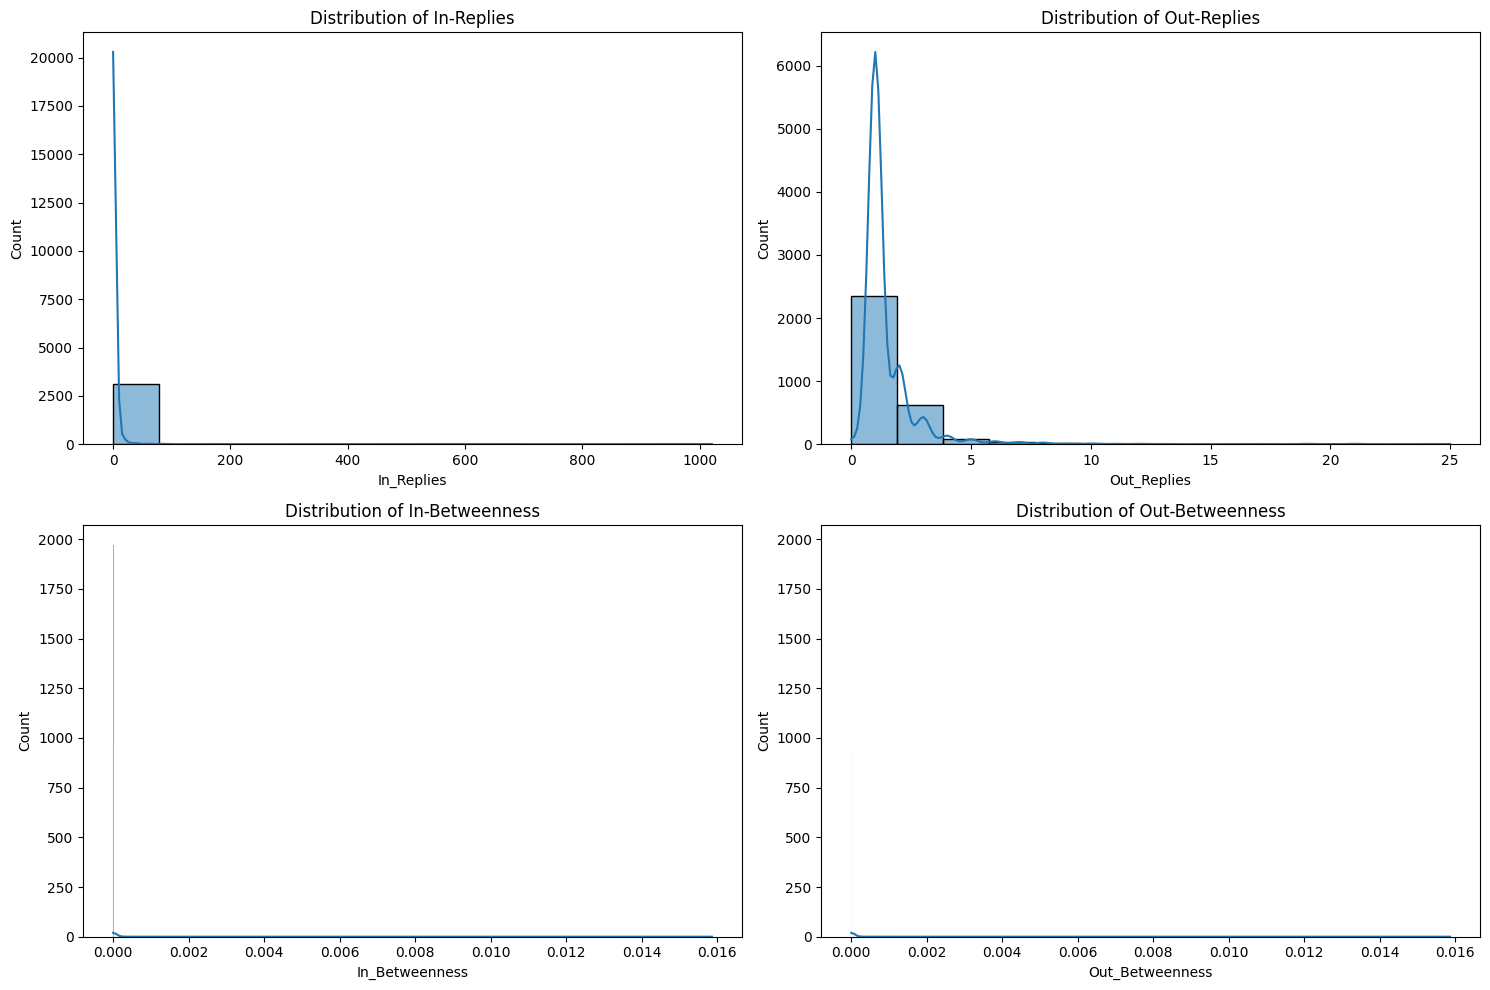

In [ ]:
# prompt: map the distribution of the four centrality

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming centrality_df is already created as in the provided code

plt.figure(figsize=(15, 10))

# Plot the distribution of each centrality measure
plt.subplot(2, 2, 1)
sns.histplot(centrality_df['In_Replies'], kde=True)
plt.title('Distribution of In-Replies')

plt.subplot(2, 2, 2)
sns.histplot(centrality_df['Out_Replies'], kde=True)
plt.title('Distribution of Out-Replies')

plt.subplot(2, 2, 3)
sns.histplot(centrality_df['In_Betweenness'], kde=True)
plt.title('Distribution of In-Betweenness')

plt.subplot(2, 2, 4)
sns.histplot(centrality_df['Out_Betweenness'], kde=True)
plt.title('Distribution of Out-Betweenness')


plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Step 1: Find top 5 nodes and their centrality values for each measure
top_in_replies = centrality_df.nlargest(5, 'In_Replies')[['Node', 'In_Replies']]
top_out_replies = centrality_df.nlargest(5, 'Out_Replies')[['Node', 'Out_Replies']]
top_in_betweenness = centrality_df.nlargest(5, 'In_Betweenness')[['Node', 'In_Betweenness']]
top_out_betweenness = centrality_df.nlargest(5, 'Out_Betweenness')[['Node', 'Out_Betweenness']]

# Step 2: Reverse the author_to_id mapping to find author names
id_to_author = {v: k for k, v in author_to_id.items()}

# Step 3: Create a DataFrame with author names and centrality values
top_authors_df = pd.DataFrame({
    "Top In-Replies": [id_to_author.get(node, "Unknown") for node in top_in_replies['Node']],
    "In-Replies Value": top_in_replies['In_Replies'].values,

    "Top Out-Replies": [id_to_author.get(node, "Unknown") for node in top_out_replies['Node']],
    "Out-Replies Value": top_out_replies['Out_Replies'].values,

    "Top In-Betweenness": [id_to_author.get(node, "Unknown") for node in top_in_betweenness['Node']],
    "In-Betweenness Value": top_in_betweenness['In_Betweenness'].values,

    "Top Out-Betweenness": [id_to_author.get(node, "Unknown") for node in top_out_betweenness['Node']],
    "Out-Betweenness Value": top_out_betweenness['Out_Betweenness'].values
})

# Display the extracted author names and values
top_authors_df


,Top In-Replies,In-Replies Value,Top Out-Replies,Out-Replies Value,Top In-Betweenness,In-Betweenness Value,Top Out-Betweenness,Out-Betweenness Value
0,Anon加重音,1021,minimonster,25,Anon加重音,0.015863,Anon加重音,0.015863
1,momo,687,M,21,Polar Bear,0.010383,Polar Bear,0.010383
2,Polar Bear,185,莫拉古,21,mono,0.008134,mono,0.008134
3,Finita!,85,Eva,20,Taka,0.006368,Taka,0.006368
4,木辛ci,83,N,19,法儿沟村花,0.005370,法儿沟村花,0.005370


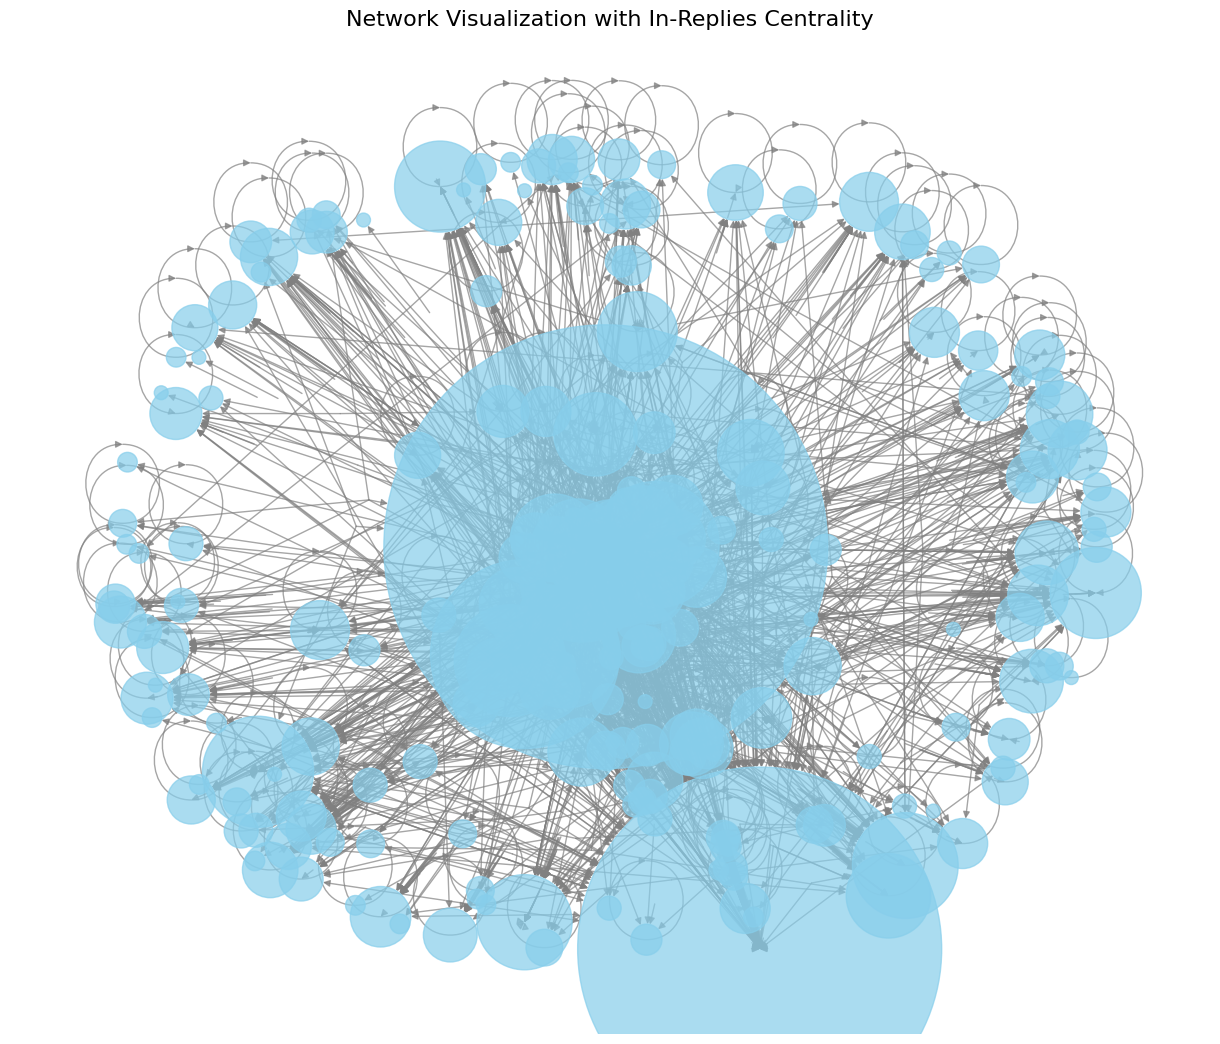

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Convert centrality_df to a dictionary for fast lookup
in_replies_dict = centrality_df.set_index('Node')['In_Replies'].to_dict()

# Compute node sizes based on in-degree centrality
node_sizes = [in_replies_dict.get(node, 1) * 100 for node in G.nodes]

# Generate a layout for better visualization
pos = nx.spring_layout(G, seed=42)  # Spring layout for spacing

# Draw the network
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color='skyblue', alpha=0.7, edge_color='gray')

# Add title
plt.title("Network Visualization with In-Replies Centrality", fontsize=16)
plt.show()


In [ ]:
# Merge centrality_df into df based on Author_ID = Node
df = df.merge(centrality_df, left_on="Author_ID", right_on="Node", how="left")

# Drop the redundant 'Node' column after merging
df = df.drop(columns=['Node'])

# Display the updated dataframe
df


,Title,Post_ID,Text,Author,Author_ID,Reply,LastReply,PublishTime,Like,Collect,...,sentiment_label,sentiment_score,Category,PostCount,ReplyCount,male_excluded,In_Replies,Out_Replies,In_Betweenness,Out_Betweenness
0,精华\n\n\n \n ...,1,由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...,Anon加重音,1,1115,2023-12-21,2020-10-09,2,4,...,positive,9.077597e-01,1,1,1,0,1021.0,9.0,0.015863,0.015863
1,精华\n\n\n \n ...,2,—————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...,Anon加重音,1,64,2023-12-01,2020-10-14,1,2,...,negative,1.599090e-01,1,2,5,0,1021.0,9.0,0.015863,0.015863
2,精华\n\n\n \n ...,3,前情(意见征集贴) https://www.douban.com/group/topic/1...,Anon加重音,1,12,2023-07-04,2020-10-10,4,6,...,positive,1.000000e+00,1,3,1,0,1021.0,9.0,0.015863,0.015863
3,精华\n\n\n \n ...,4,论坛第二期分享会她说PhD：不同的人生路径的文字稿和音频分享来啦。非常感谢小组长们的全力支持...,Sophie,2,2,2023-05-03,2020-11-02,1,6,...,positive,9.999413e-01,1,1,0,0,2.0,0.0,0.000216,0.000216
4,精华\n\n\n \n ...,5,09/30/21更新: 管理员实在是没有能力及时追踪所有申请相关的帖子，大家有相关的帖子想要...,丸子,3,6,2023-03-25,2020-12-09,2,2,...,negative,2.440807e-08,1,1,1,0,10.0,1.0,0.000453,0.000453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5249,分享一个本领域senior的采访内容,4331,这位前辈人非常好，成果很多，采访内容里虽然不少是本领域specific，但是其中关于pick...,路亦槑,2087,1,2020-09-19,2020-09-19,6,2,...,positive,9.880279e-01,1,3,0,0,0.0,1.0,0.000011,0.000011
5250,精华\n\n\n \n ...,4332,组里真是人才济济呀，为了更好地整合与利用资源，将所有AMA帖子集合在这里，方便大家交流学习P...,Anon加重音,1,0,2020-09-19,2020-09-19,3,2,...,positive,9.999863e-01,1,26,0,0,1021.0,9.0,0.015863,0.015863
5251,AMA｜美国文理学院做教职（理科）,4333,如题，关于美国文理学院（理科）教职申请、工作日常、工作环境、晋升要求、职业发展，欢迎提问！先...,多喜子,2447,4,2020-09-19,2020-09-18,5,7,...,positive,9.908972e-01,1,1,0,0,NaN,NaN,NaN,NaN
5252,精华\n\n\n \n ...,4332,组里真是人才济济呀，为了更好地整合与利用资源，将所有AMA帖子集合在这里，方便大家交流学习P...,Anon加重音,1,0,2020-09-19,2020-09-19,3,2,...,positive,9.999863e-01,1,27,0,0,1021.0,9.0,0.015863,0.015863


In [ ]:
df.shape

(5254, 24)

In [ ]:
# Fill missing centrality values with 0
df[['In_Replies', 'Out_Replies', 'In_Betweenness', 'Out_Betweenness']] = df[
    ['In_Replies', 'Out_Replies', 'In_Betweenness', 'Out_Betweenness']
].fillna(0)

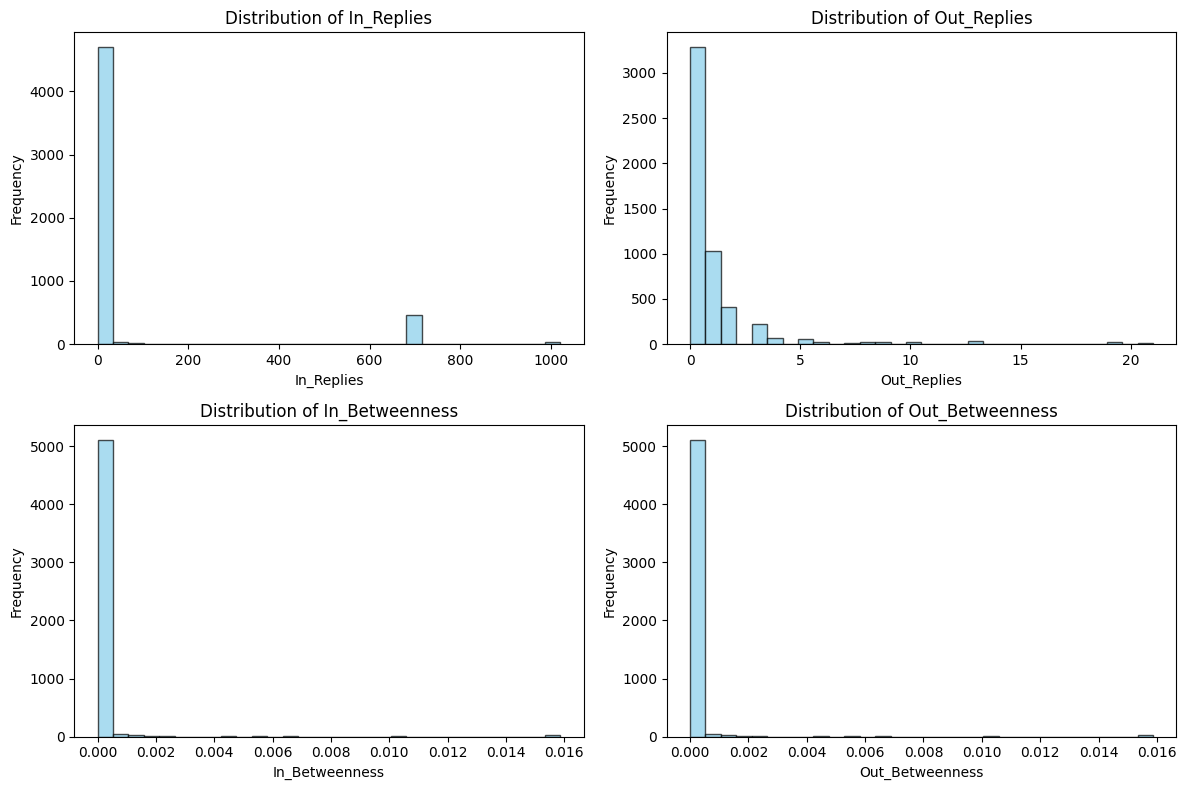

In [ ]:
import matplotlib.pyplot as plt

# Define the centrality columns to visualize
centrality_columns = ['In_Replies', 'Out_Replies', 'In_Betweenness', 'Out_Betweenness']

# Set up the figure for subplots
plt.figure(figsize=(12, 8))

# Generate histograms for each centrality measure
for i, col in enumerate(centrality_columns, 1):
    plt.subplot(2, 2, i)  # 2x2 layout
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the percentage of non-zero values for each centrality measure
non_zero_percentages = {
    col: (df[col] != 0).sum() / len(df) * 100 for col in ['In_Replies', 'Out_Replies', 'In_Betweenness', 'Out_Betweenness']
}

# Convert to a DataFrame for better visualization
non_zero_df = pd.DataFrame.from_dict(non_zero_percentages, orient='index', columns=['Non-Zero Percentage'])

# Display the results
non_zero_df


,Non-Zero Percentage
In_Replies,20.022840
Out_Replies,37.495242
In_Betweenness,47.392463
Out_Betweenness,47.392463


In [ ]:
df.drop(columns=['active_author',
       'active_reply_author'], inplace=True)

In [ ]:
df.columns

Index(['Title', 'Post_ID', 'Text', 'Author', 'Author_ID', 'Reply', 'LastReply',
       'PublishTime', 'Like', 'Collect', 'Repost', 'Length', 'sentiment_label',
       'sentiment_score', 'Category', 'PostCount', 'ReplyCount',
       'male_excluded', 'In_Replies', 'Out_Replies', 'In_Betweenness',
       'Out_Betweenness'],
      dtype='object')

In [ ]:
# prompt: save df to "working_data.csv"

df.to_csv('/content/drive/MyDrive/MA_Thesis/DBCommunity/saved_data/working_data.csv', index=False)
